# Upload this notebook to colab.
All the necessary python libraries have been included.

In [ ]:
# @title Copyright & License (click to expand)
# MIT License

# Copyright (c)
# Jiale Shi
# 2024 olsenlabmit

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import and Install Necessary Libraries

In [11]:
# import necessary libraries available in colab
import numpy as np
import matplotlib.pyplot as plt
import shutil
import sys
import os.path
import json
import seaborn as sns
import pandas as pd

# install necessary libraries not available in colab
if not shutil.which("rdkit"):
    !pip install -q rdkit

# https://pythonot.github.io/auto_examples/plot_Intro_OT.html#sphx-glr-auto-examples-plot-intro-ot-py
if not shutil.which("ot"):
    !pip install pot

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem.rdFingerprintGenerator import GetRDKitFPGenerator
import ot
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import pairwise_distances
from scipy.optimize import minimize
from scipy.stats import bernoulli
from scipy.special import expit as sigmoid
from sklearn.datasets import make_moons
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic

# Similarity Score Functions

## Earth Mover's Distance (EMD) Similarity Function

Use the earth mover's distance to compute similarity for repeating units and end groups.


$ EMD (P,Q)= \min_{F}\sum_{i=1}^{m}\sum_{j=1}^{n}f_{i,j}d_{i,j}$

$ {\rm subject\ to\ } f_{i,j} \geq 0, {\rm\ for\ any\ } \ 1 \leq i \leq m, 1 \leq j \leq n $

$     \sum_{j=1}^{n}f_{i,j} =w_{pi}, {\rm for\ any} \ 1 \leq i \leq m $

$     \sum_{i=1}^{m}f_{i,j} =w_{qj}, {\rm for\ any} \ 1 \leq j \leq n $

$     \sum_{i=1}^{m}\sum_{j=1}^{n}f_{i,j} = \sum_{i}^{m} w_{pi} = \sum_{j}^{n} w_{qj} = 1 $


Molecular fragment ensemble $P = \{(p_1,w_{p_1}) ,(p_2,w_{p_2}),...,(p_i,w_{p_i}),...,(p_m,w_{p_m})\}$ has $m$ molecular fragments, where $p_i$ is a molecular fragment such as a repeat unit or end group and $w_{p_i}>0$ is the weight, related to the average probability (or frequency, $z$) of the molecular fragment being present in the polymer. Similarly, the second ensemble $Q = {(q_1,w_{q_1}),(q_2,w_{q_2}),...,(q_j,w_{q_j}),...,(q_n,w_{q_n})}$ has $n$ molecular fragments.  The sums of the weights for $P$ and $Q$ are both normalized and equal to one.
The distance $d_{i,j}$ is calculated by the converting the pairwise similarity score $s_{i,j}$ between $p_{i}$ and $q_{j}$, where $d_{i,j} = 1 - s_{i,j}$.
Transport flow $f_{i,j}$ represents the amount of weight at $p_i$ which is transported to $q_j$.

## Using library pot (no pyomo and cbc)

In [3]:
def EMD_Calculation_pot(
    query_smiles_list=None,
    query_smiles_weight_list=None,
    target_smiles_list=None,
    target_smiles_weight_list=None,
    embedding_function="MorganFingerprint",
    similarity_score_function="Tanimoto",
    radius = 2,
    num_bits = 2048,
):
    # obtain the length of query smiles list and target smiles list
    query_smiles_list_length = len(query_smiles_list)

    target_smiles_list_length = len(target_smiles_list)

    query_smiles_weight_list = list(np.ones([query_smiles_list_length]))

    target_smiles_weight_list = list(np.ones([target_smiles_list_length]))


    # transfer SMILES to fingerprints
    if embedding_function == "RDKFingerprint":

        fpgen = GetRDKitFPGenerator(fpSize=num_bits)

        #fps = [fpgen.GetFingerprint(x) for x in ms]

        query_mol_list = [Chem.MolFromSmiles(x) for x in query_smiles_list]
        query_fingerprint_list = [fpgen.GetFingerprint(x)for x in query_mol_list]
        target_mol_list = [Chem.MolFromSmiles(x) for x in target_smiles_list]
        target_fingerprint_list = [fpgen.GetFingerprint(x) for x in target_mol_list]

    elif embedding_function == "MorganFingerprint":
        query_mol_list = [Chem.MolFromSmiles(x) for x in query_smiles_list]
        query_fingerprint_list = [
            AllChem.GetMorganFingerprintAsBitVect(x, radius, nBits=num_bits)
            for x in query_mol_list
        ]
        target_mol_list = [Chem.MolFromSmiles(x) for x in target_smiles_list]
        target_fingerprint_list = [
            AllChem.GetMorganFingerprintAsBitVect(x, radius, nBits=num_bits)
            for x in target_mol_list
        ]

    elif embedding_function == "MACCSkeys":
        query_mol_list = [Chem.MolFromSmiles(x) for x in query_smiles_list]
        query_fingerprint_list = [MACCSkeys.GenMACCSKeys(x) for x in query_mol_list]
        target_mol_list = [Chem.MolFromSmiles(x) for x in target_smiles_list]
        target_fingerprint_list = [MACCSkeys.GenMACCSKeys(x) for x in target_mol_list]

    else:
        print(
            embedding_function
            + " is not included in the current vision."
            + " Please choose an available embedding function:"
        )
        print("MorganFingerprint, RDKFingerprint, MACCSkeys.")
        return False

    # define the required three sets
    C = np.zeros([query_smiles_list_length,target_smiles_list_length ])

    # use similarity function to calculate d_ij
    if similarity_score_function == "Tanimoto":
        for i in range(0, query_smiles_list_length):
            for j in range(0, target_smiles_list_length):
                C[i,j] = 1 - DataStructs.FingerprintSimilarity(
                    query_fingerprint_list[i], target_fingerprint_list[j],
                    metric=DataStructs.TanimotoSimilarity

                )

    elif similarity_score_function == "Dice":
        for i in range(0, query_smiles_list_length):
            for j in range(0, target_smiles_list_length):
                C[i,j] = 1 - DataStructs.FingerprintSimilarity(
                    query_fingerprint_list[i], target_fingerprint_list[j],
                    metric=DataStructs.DiceSimilarity
                )

    elif similarity_score_function == "Cosine":
        for i in range(0, query_smiles_list_length):
            for j in range(0, target_smiles_list_length):
                C[i,j] = 1 - DataStructs.FingerprintSimilarity(
                    query_fingerprint_list[i], target_fingerprint_list[j],
                    metric=DataStructs.CosineSimilarity
                )

    else:
        print(
            similarity_score_function
            + " is not included in the current vision."
            + " Please choose an available similarity function:"
        )
        print("Tanimoto, Dice, or Cosine")
        return

    #print(C)
    query_smiles_weight_array = np.array(query_smiles_weight_list)/sum(np.array(query_smiles_weight_list))
    target_smiles_weight_array = np.array(target_smiles_weight_list)/sum(np.array(target_smiles_weight_list))
    #print(query_smiles_weight_array, target_smiles_weight_array)
    ot_emd = ot.emd(query_smiles_weight_array, target_smiles_weight_array, C)
    #print(ot_emd)

    W = np.sum(ot_emd * C)
    #print(W)
    return W


# Polyester with two repeat units

In [39]:
D_test = EMD_Calculation_pot(
            query_smiles_list=["OCCO", "C(=O)CCC(=O)"],
            query_smiles_weight_list=[1,1],
            target_smiles_list=["OCCCCO", "C(=O)CCCCC(=O)"],
            target_smiles_weight_list=[1,1],
            embedding_function="RDKFingerprint",
            similarity_score_function="Tanimoto",
            radius = 5,
            num_bits = 512,
            )

print(D_test)

0.5533333333333333


# Polyester with three repeat units

In [41]:
D_test = EMD_Calculation_pot(
            query_smiles_list=[ "C(=O)CCC(=O)", "C(=O)CC(CC)CC(=O)","OCCO"],
            query_smiles_weight_list=[1,1,2],
            target_smiles_list=["C(=O)CCCCC(=O)", "OCCCCO",  "OCCO",],
            target_smiles_weight_list=[2, 1.1, 0.9],
            embedding_function="RDKFingerprint",
            similarity_score_function="Tanimoto",
            radius = 5,
            num_bits = 512,
            )

print(D_test)

0.43219512195121945


In [25]:
!wget https://github.com/shijiale0609/PolymerPhysicsHub/raw/main/pnas_biodegradability_polish_data.pkl

--2024-03-09 00:31:38--  https://github.com/shijiale0609/PolymerPhysicsHub/raw/main/pnas_biodegradability_polish_data.pkl
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shijiale0609/PolymerPhysicsHub/main/pnas_biodegradability_polish_data.pkl [following]
--2024-03-09 00:31:38--  https://raw.githubusercontent.com/shijiale0609/PolymerPhysicsHub/main/pnas_biodegradability_polish_data.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156011 (152K) [application/octet-stream]
Saving to: ‘pnas_biodegradability_polish_data.pkl’

pnas_biodegradabili 100%[===================>] 152.35K  --.-KB/s    in 0

In [26]:
document1 = pd.read_pickle('pnas_biodegradability_polish_data.pkl')

In [29]:
EMD_Dict = {}
for i in np.arange(0, 661):
    if i % 10 == 0:
        print(i)
    for j in np.arange(0,661):
            key_i = document1['Notebook number'][i]
            key_j = document1['Notebook number'][j]

            key = key_i + "," + key_j
            if key in EMD_Dict:
                print(i,j, key, "Done")
                continue

            D_i_j = EMD_Calculation_pot(
                query_smiles_list = document1["RepeatUnitsList"][i],
                query_smiles_weight_list = None,
                target_smiles_list = document1["RepeatUnitsList"][j],
                target_smiles_weight_list = None,
                embedding_function = "RDKFingerprint",
                similarity_score_function = "Tanimoto",
                radius = 5,
                num_bits = 512,
                )

            EMD_Dict[key] = D_i_j
            #print(i,j, key)

    # Writing JSON data
    with open('EMD_Dict.json', 'w') as file:
        json.dump(EMD_Dict, file)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660


# Organize the index order the Distance Matrix to be 1-109 is test data, 110-656 is train data.

In [30]:
!wget https://github.com/shijiale0609/PolymerPhysicsHub/raw/main/test_train_ID.npy
!wget https://github.com/shijiale0609/PolymerPhysicsHub/raw/main/test_train_biodegradability.npy

--2024-03-09 00:55:51--  https://github.com/shijiale0609/PolymerPhysicsHub/raw/main/test_train_ID.npy
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shijiale0609/PolymerPhysicsHub/main/test_train_ID.npy [following]
--2024-03-09 00:55:51--  https://raw.githubusercontent.com/shijiale0609/PolymerPhysicsHub/main/test_train_ID.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21120 (21K) [application/octet-stream]
Saving to: ‘test_train_ID.npy.1’

test_train_ID.npy.1 100%[===================>]  20.62K  --.-KB/s    in 0s      

2024-03-09 00:55:51 (78.5 MB/s) - ‘test_train_ID.npy.1’ saved [21120/21

In [31]:
test_train_ID = np.load("test_train_ID.npy")
test_train_biodegradability = np.load("test_train_biodegradability.npy")
test_ix = np.arange(0,109)
train_ix = np.arange(109,656)

In [32]:
EMD_array = np.zeros([656,656])

for i in np.arange(0, 656):
    key_i = test_train_ID[i]

    for j in np.arange(0,656):

          key_j = test_train_ID[j]

          key = key_i + ',' + key_j
          EMD_array[i,j] = EMD_Dict[key]

<Axes: >

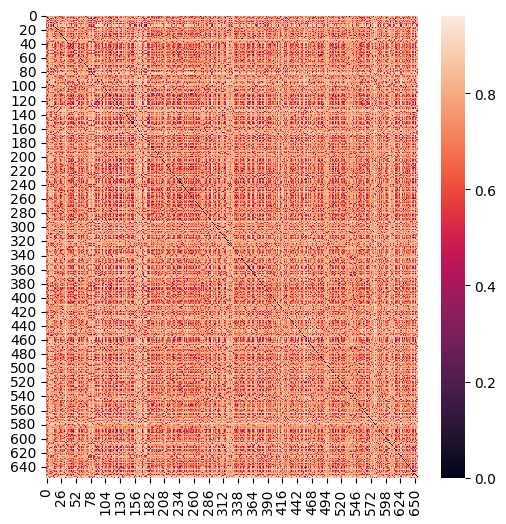

In [33]:
plt.figure(figsize = (6,6))
sns.heatmap(EMD_array)

In [34]:
y_train = test_train_biodegradability[train_ix]
y_test = test_train_biodegradability[test_ix]

In [35]:
X_train = EMD_array[train_ix]
X_test = EMD_array[test_ix]

# Randome Forest Classification

In [36]:
rfc = RandomForestClassifier(n_estimators=2**10,
                               max_depth= 13,
                               min_samples_split=4,
                               min_samples_leaf=1,
                               max_leaf_nodes=20)

rfc.fit(X_train, y_train)
rfc_score = rfc.score(X_test, y_test)
rfc_score

0.7981651376146789

# Gaussian Processes Classification

In [37]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpc = GaussianProcessClassifier(kernel=rbf)
gpc.fit(X_train, y_train)
gpc_score = gpc.score(X_test,y_test)
gpc_score

0.8165137614678899